In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import itertools as it
import networkx as nx
import random
import operator
import warnings
warnings.filterwarnings('ignore')

1)

In [2]:
def analizar_grafo(grafo):

    
    print("Cantidad de nodos: {0}".format(grafo.number_of_nodes()))
    print("Cantidad de aristas: {0}".format(grafo.number_of_edges()))
    
    """
    print("Cantidad de componentes conexas: ", len(componentes_conexas))
    print("Cantidad de nodos de la componente conexa gigante: ", tupla_componente_gigante[1])
    
    G = grafo.subgraph(tupla_componente_gigante[0])
    
    print("Segunda Componente :")
    segunda = grafo.copy()
    segunda.remove_nodes_from(G)
    if segunda.number_of_nodes() > 0 :
        componentes_conexas = [x for x in nx.connected_components(segunda)]
        tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

        print("Cantidad de nodos: {0}".format(segunda.number_of_nodes()))
        print("Cantidad de aristas: {0}".format(segunda.number_of_edges()))
        print("Cantidad de componentes conexas: ", len(componentes_conexas))
        print("Cantidad de nodos de la componente conexa gigante: ", tupla_componente_gigante[1])
    
    return G
    """

In [21]:
def calcular_componentes_conexas_ordenadas(grafo):
    componentes_conexas = [x for x in nx.connected_components(grafo)]
    return sorted([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1], reverse=True)

def calcular_componente_conexa_gigante(grafo):
    return grafo.subgraph((calcular_componentes_conexas_ordenadas(grafo)[0])[0])

def calcular_componente_conexa_iesima(grafo,i):
    return grafo.subgraph((calcular_componentes_conexas_ordenadas(grafo)[i])[0])

In [4]:
G = nx.Graph()

with open('./data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        autores = [autor.strip() for autor in row[3].split('&')]
        coautorias = it.combinations(autores, 2)
        G.add_edges_from(coautorias)


In [5]:
analizar_grafo(G)

Cantidad de nodos: 3698
Cantidad de aristas: 7880


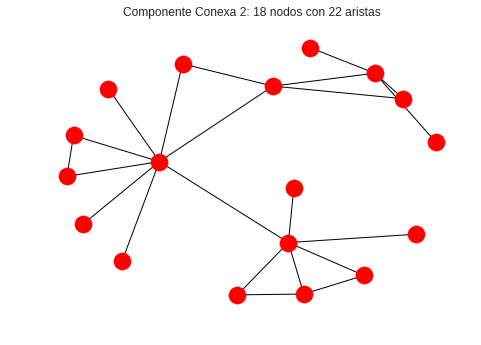

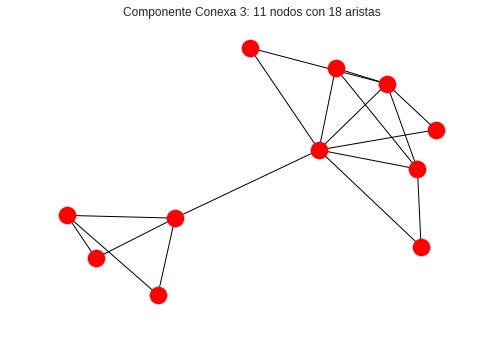

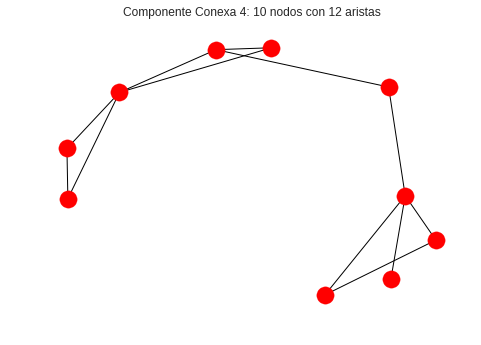

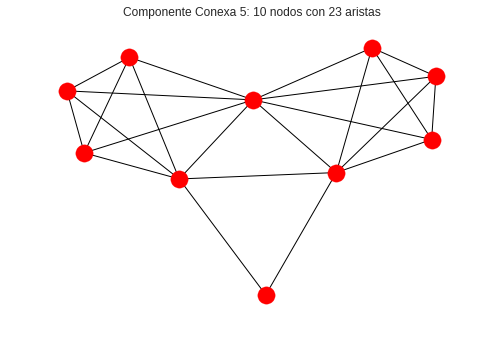

In [7]:
# Elegimos plotear desde la segunda componente conexa hasta la n
n = 5
componentes_conexas_ordenadas = calcular_componentes_conexas_ordenadas(G)
for i in range(1,n):
    grafo = G.subgraph(componentes_conexas_ordenadas[i][0])
    plt.figure()
    plt.title("Componente Conexa {0}: {1} nodos con {2} aristas".format(i+1, grafo.number_of_nodes(), grafo.number_of_edges()))
    nx.draw(grafo)

2)

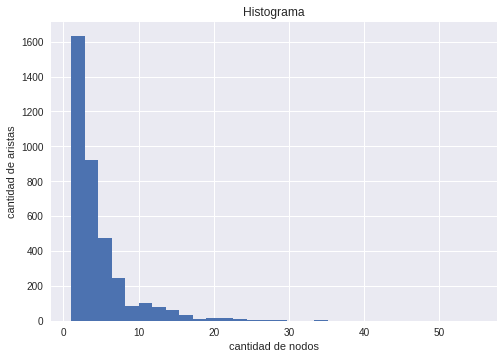

In [8]:
grados = list(nx.degree(G).values())
dist, bins, patches = plt.hist(grados, bins=30)
plt.title("Histograma")
plt.xlabel("cantidad de nodos")
plt.ylabel("cantidad de aristas")
plt.show()


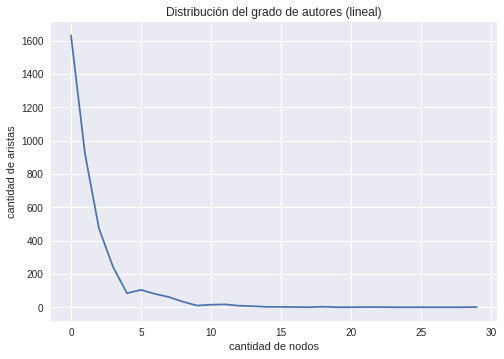

In [9]:
plt.title("Distribución del grado de autores (lineal)")
plt.xlabel("cantidad de nodos")
plt.ylabel("cantidad de aristas")
plt.plot(dist)

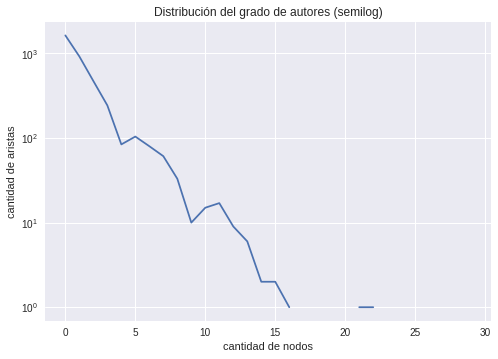

In [10]:
plt.title("Distribución del grado de autores (semilog)")
plt.xlabel("cantidad de nodos")
plt.ylabel("cantidad de aristas")
plt.semilogy(dist)

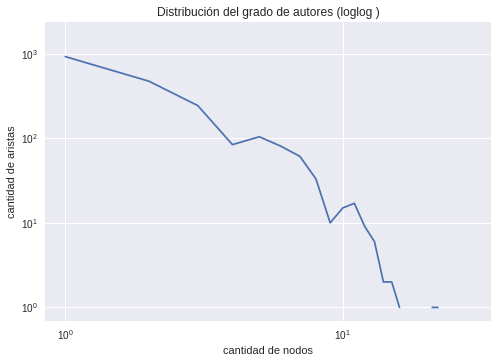

In [11]:
plt.title("Distribución del grado de autores (loglog )")
plt.xlabel("cantidad de nodos")
plt.ylabel("cantidad de aristas")
plt.loglog(dist)

Podemos observar que al graficar la distribución en escala semilog obtenemos un gráfico que se asemeja mucho más a uno lineal que al graficarla con la escala loglog, por lo tanto pareciera ser que se trata de una distribución exponencial.

3)

In [12]:
componente_conexa_gigante = G.subgraph(componentes_conexas_ordenadas[0][0])

print("cantidad de componentes conexas: ", len(componentes_conexas_ordenadas))
analizar_grafo(componente_conexa_gigante)

cantidad de componentes conexas:  236
Cantidad de nodos: 3018
Cantidad de aristas: 7269


4)

In [13]:
def invert_map(map):
    inv_map = {}
    for k, v in map.items():
        inv_map.setdefault(v, [])
        inv_map[v].append(k)
    return inv_map

def authors_by_distance(componente_gigante):
    nodo_raiz_idx = random.randint(0, len(componente_gigante) - 1)
    nodo_raiz = componente_gigante.nodes()[nodo_raiz_idx]

    paths = invert_map(all_distances[nodo_raiz])
    diferencial = {}
    
    previous_quantity = 0
    for distance in sorted(paths.keys()):
        diferencial[distance] = len(paths[distance]) 
        
    return diferencial

In [14]:
all_distances = nx.all_pairs_shortest_path_length(componente_conexa_gigante)

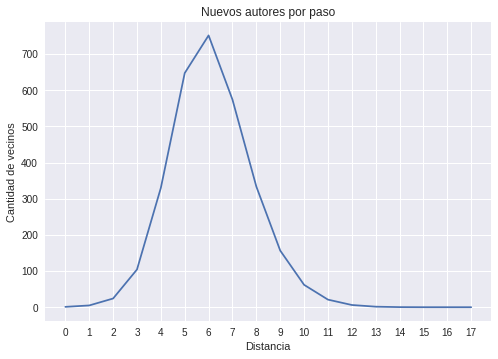

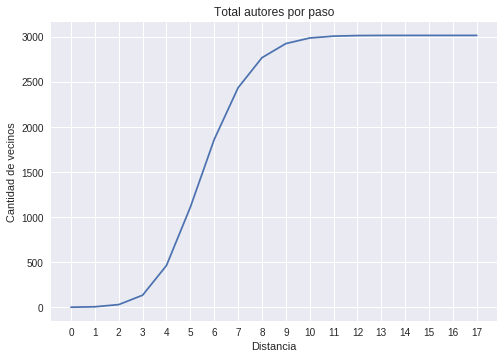

In [15]:
iterations = 2000
longest_path = max([max(node_distances.values()) for node_distances in all_distances.values()]) + 1
results = np.zeros((iterations, longest_path), dtype=int)

for iteration in range(iterations):
    diferencial = authors_by_distance(componente_conexa_gigante)
    
    for distance, quantity in diferencial.items():
        results[iteration, distance] = quantity

diferencial_means = results.mean(axis=0)
incremental_means = []

previous_quantity = 0
for quantity in diferencial_means:
    incremental_means.append(quantity + previous_quantity)
    previous_quantity = quantity + previous_quantity

def plot(y, title):
    sns.plt.figure()
    sns.plt.title(title)
    sns.plt.ylabel("Cantidad de vecinos")
    sns.plt.xlabel("Distancia")
    sns.plt.xticks(range(longest_path+1))
    sns.plt.plot(range(longest_path),y)

plot(diferencial_means, "Nuevos autores por paso")
plot(incremental_means, "Total autores por paso")

In [16]:
max_diferencial_index = np.argmax(diferencial_means)
print("A los {0} nodos de distancia se encuentra la mayor cantidad de vecinos agregados: {1}" \
     .format(max_diferencial_index, diferencial_means[max_diferencial_index]))

A los 6 nodos de distancia se encuentra la mayor cantidad de vecinos agregados: 751.4975


Para este punto tomamos un nodo al azar de la mayor componente conexa y calculamos cuantos nodos se iban agregando mientras nos alejabamos de a un paso, y cuantos vecinos en total en cada paso dispone el nodo elegido.

Este experimento lo realizamos una gran cantidad de iteraciones y graficamos el promedio de todos los valores para ganar mayor robustez en el resultado.

Como podemos observar, claramente es a los 6 grados de distancia cuando se agrega la mayor cantidad de vecinos. A partir de allí, decrementa la cantidad de vecinos que se suman.

5)

In [17]:
clustering = nx.average_clustering(componente_conexa_gigante)
avg_shortest_path_length = nx.average_shortest_path_length(componente_conexa_gigante)

degrees_seq = list(dict(componente_conexa_gigante.degree()).values())
# Hago un grafo aleatorio con la distribución de grados
GR = nx.configuration_model(degrees_seq, create_using=nx.Graph())


#Me quedo con la componente conexa más grande del grafo aleatoreo
componente_conexa_gigante_GR = calcular_componente_conexa_gigante(GR)

random_G = GR.subgraph(componente_conexa_gigante_GR)
print(nx.Graph(random_G))

clustering_random = nx.average_clustering(random_G)
avg_shortest_path_length_random = nx.average_shortest_path_length(random_G)

print('Grafo componente gigante:')
print('\tClustering: {0}'.format(clustering))
print('\tCamino minimo medio: {0}'.format(avg_shortest_path_length))

print(u'Grafo aleatorio con la misma distribución:')
print('\tClustering: {0}'.format(clustering_random))
print('\tCamino minimo medio: {0}'.format(avg_shortest_path_length_random))

configuration_model 3018 nodes 7244 edges
Grafo componente gigante:
	Clustering: 0.48400143699699083
	Camino minimo medio: 6.131037221593651
Grafo aleatorio con la misma distribución:
	Clustering: 0.0036562047662732
	Camino minimo medio: 4.746502664779073


6)
Para identificar un autor "estrella", pensamos que los mismos pueden ser aquellos que trabajan en colaboraciones en varios papers. Esto no habla de la capacidad en si de dicho autor, pero por lo menos se puede identificar cauntitativamente autores que tienen un aporte interesante (por lo menos en la cantidad de publicaciones realizadas) a la comunidad. Para hacer un análisis cualitativo es necesario trabajar sobre las publicaciones en párticular y tener alguna noción de la importancia o relevancia de los paper publicados.

Como nocion más rápida de importancia en funcion de la cantidad de colaboraciones es la del grado en este grafo. Recordemos que por cada colaboracion de este auto en un paper, tiene una arista contra todos los participantes del mismo. Por lo tanto, muchas aristas son muchas colaboraciones y es lo que estbamos buscando.

Luego para mejorar este mecanismo, vamos a pensar en la idea del betweetness, que trabaja en función de la aparición del nodo en los caminos minimos del grafo, con lo cual creemos que mejora la calidad del autor seleccionado como estrella, porque no solo importa el grado de dicho autor, si no su aparicion dentro de los caminos mínimos de todo el grafo y su intrconección.

In [24]:
def analizar_centralidad(grafo, repeticiones, degree):
    completo = grafo.copy()

    diferencias = np.empty(repeticiones)

    for i in range(repeticiones):
        print("iteracion: ", i)
        componente_gigante = calcular_componente_conexa_gigante(completo)
        analizar_grafo(componente_gigante)
        
        nPrimera = componente_gigante.number_of_nodes()
        nSegunda = calcular_componente_conexa_iesima(completo,1).number_of_nodes()
        
        diferencias[i] = nPrimera - nSegunda
        
        if degree :
            degree_centralty = nx.degree_centrality(componente_gigante)
        else :
            betweenness_centralty = nx.betweenness_centrality(componente_gigante)
        
        if degree :
            important_node = max(degree_centralty.items(), key=operator.itemgetter(1))[0]
        else :
            important_node = max(betweenness_centralty.items(), key=operator.itemgetter(1))[0]
        
        completo.remove_node(important_node)
        print()
    return diferencias

In [25]:
difDegree = analizar_centralidad(G,450,True)

#difBetweetness = analizar_centralidad(G,450,False)

iteracion:  0
Cantidad de nodos: 3018
Cantidad de aristas: 7269

iteracion:  1
Cantidad de nodos: 3013
Cantidad de aristas: 7215

iteracion:  2
Cantidad de nodos: 3012
Cantidad de aristas: 7174

iteracion:  3
Cantidad de nodos: 3007
Cantidad de aristas: 7137

iteracion:  4
Cantidad de nodos: 3006
Cantidad de aristas: 7102

iteracion:  5
Cantidad de nodos: 2998
Cantidad de aristas: 7066

iteracion:  6
Cantidad de nodos: 2997
Cantidad de aristas: 7033

iteracion:  7
Cantidad de nodos: 2995
Cantidad de aristas: 7004

iteracion:  8
Cantidad de nodos: 2994
Cantidad de aristas: 6976

iteracion:  9
Cantidad de nodos: 2993
Cantidad de aristas: 6949

iteracion:  10
Cantidad de nodos: 2990
Cantidad de aristas: 6923

iteracion:  11
Cantidad de nodos: 2988
Cantidad de aristas: 6897

iteracion:  12
Cantidad de nodos: 2986
Cantidad de aristas: 6871

iteracion:  13
Cantidad de nodos: 2982
Cantidad de aristas: 6845

iteracion:  14
Cantidad de nodos: 2979
Cantidad de aristas: 6820

iteracion:  15
Canti

iteracion:  128
Cantidad de nodos: 2540
Cantidad de aristas: 4604

iteracion:  129
Cantidad de nodos: 2538
Cantidad de aristas: 4593

iteracion:  130
Cantidad de nodos: 2534
Cantidad de aristas: 4581

iteracion:  131
Cantidad de nodos: 2532
Cantidad de aristas: 4570

iteracion:  132
Cantidad de nodos: 2530
Cantidad de aristas: 4559

iteracion:  133
Cantidad de nodos: 2528
Cantidad de aristas: 4548

iteracion:  134
Cantidad de nodos: 2527
Cantidad de aristas: 4537

iteracion:  135
Cantidad de nodos: 2526
Cantidad de aristas: 4526

iteracion:  136
Cantidad de nodos: 2524
Cantidad de aristas: 4515

iteracion:  137
Cantidad de nodos: 2505
Cantidad de aristas: 4482

iteracion:  138
Cantidad de nodos: 2503
Cantidad de aristas: 4471

iteracion:  139
Cantidad de nodos: 2501
Cantidad de aristas: 4460

iteracion:  140
Cantidad de nodos: 2498
Cantidad de aristas: 4449

iteracion:  141
Cantidad de nodos: 2494
Cantidad de aristas: 4437

iteracion:  142
Cantidad de nodos: 2490
Cantidad de aristas: 4

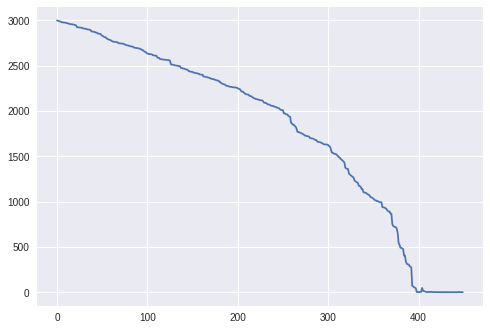

In [26]:
plt.plot(difDegree)

In [ ]:
plt.plot(difBetweetness)

Hablar del chamuyo de que pensabamos que en pocos pasos se iban a separar las comunidades y nos dió que alrededor del 10% DE LOS AUTORES MAS IMPORTANTES HAY QUE BORRAR PARA ROMPERLO

hacer algún gráfico loco